# Feature Qualitätsmodell mit der DIM-Toolbox

Ziel des Tutorials ist den Workflow zur Identifikation von Feature-Qualitätsmodellen für den Spritzgießprozess mit der DIM-Toolbox zu veranschaulichen.

Die für das Modelltraining (Schätzung der Modellparameter) und die Modellvalidierung verwendeten Daten wurden im Rahmen eines umfangreichen Versuchsplanes erhoben. Der Trainingsdatensatz umfasst die Daten von 2105 Produktionszyklen, der Validierungsdatensatz umfasst die Daten von 548 Produktionszyklen.

In [20]:
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import sys
path_dim = Path.cwd().parents[1]

sys.path.insert(0, path_dim.as_posix())

from DIM.miscellaneous.PreProcessing import LoadFeatureData,LoadSetpointData,MinMaxScale
from DIM.models.model_structures import Static_MLP
from DIM.optim.param_optim import ModelTraining, static_mode
from DIM.optim.common import BestFitRate

Spezifiziere Pfad zur Datenbasis und welche Chargen für Modellbildung und -validierung verwendet werden sollen 

In [21]:
path = path_dim / 'data/Versuchsplan/normalized/'
charges = list(range(1,275))
split = 'all' 

Spezifiziere Ein- und Ausgangsgrößen für das Qualitätsmodell

In [22]:
u_label_q = ['T_wkz_0', 'T_wkz_max', 't_Twkz_max', 'T_wkz_int', 'p_wkz_max',
'p_wkz_int', 'p_wkz_res', 't_pwkz_max']

y_label_q = ['Durchmesser_innen']

Die Funktion LoadFeatureData() berechnet aus den Prozessgrößen jedes Spritzgießzykluses einige Features und teilt die Daten in Trainings- und Validierungsdaten ein

In [23]:
data_train,data_val = LoadFeatureData(path.as_posix(),charges,split,True)

In [24]:
print(data_train)

      Charge  Düsentemperatur  Werkzeugtemperatur  Einspritzgeschwindigkeit  \
11         1              250                  40                        16   
12         1              250                  40                        16   
14         1              250                  40                        16   
15         1              250                  40                        16   
16         1              250                  40                        16   
...      ...              ...                 ...                       ...   
2777     274              260                  50                        48   
2778     274              260                  50                        48   
2780     274              260                  50                        48   
2781     274              260                  50                        48   
2782     274              260                  50                        48   

      Umschaltpunkt  Nachdruckhöhe  Nachdruckzeit  

Es ist insbesondere bei der Verwendung Neuronaler Netze zweckmäßig, die Daten auf das Intervall [-1,1] zu skalieren, das geschieht mittels der Funktion MinMaxScale()

In [25]:
data_train,minmax = MinMaxScale(data_train,u_label_q+y_label_q)
data_val,_ = MinMaxScale(data_val,u_label_q+y_label_q,minmax=minmax)

Plotte eine Untermenge der Validierungsdaten zu Visualisierungszwecken

<AxesSubplot:ylabel='Durchmesser_innen'>

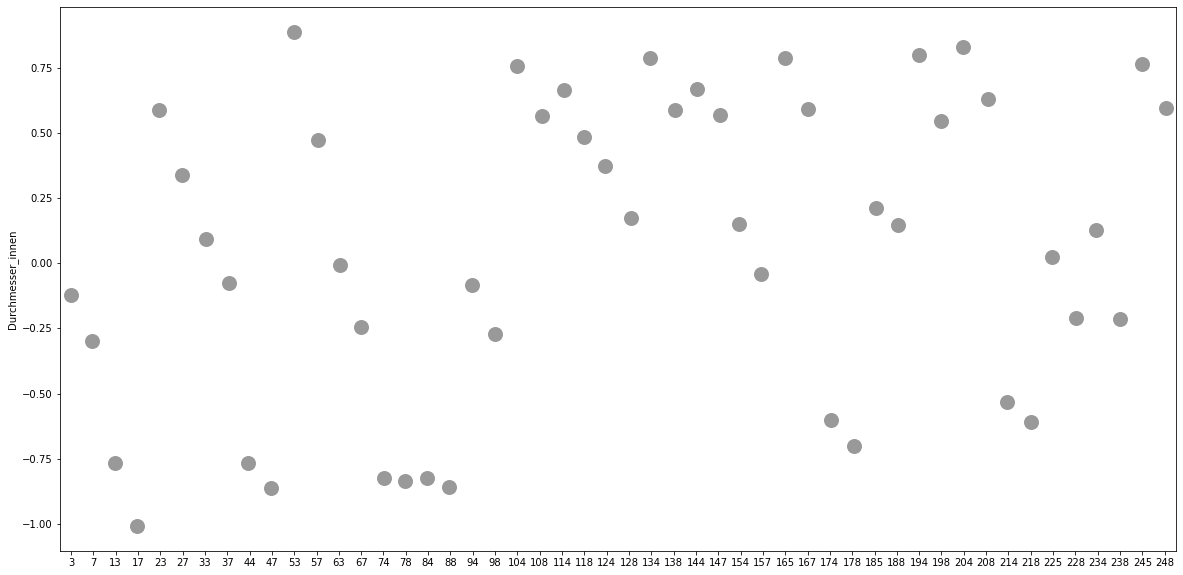

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))

idx_plot = data_val.index[0:50]

sns.stripplot(x=idx_plot,y=data_val.loc[idx_plot,'Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)

Ein Neuronales Netz, welches Eingangsgrößen statisch auf Ausgangsgrößen abbildet ist Static_MLP. Bei der Erzeugung einer Instanz der Klasse Static_MLP müssen einige Parameter festgelegt werden:

| Parameter | Typ | Erläuterung |
| --- | --- | :-- |
|dim_u : |int |Anzahl an Modelleingängen |
|dim_hidden | int | Anzahl der Modellausgänge |
|u_label| list of str |Namen der Eingangsgrößen, muss mit den Spaltenüberschriften in data_train, data_val übereinstimmen|
|y_label| list of str |Namen der Ausgangsgrößen, muss mit den Spaltenüberschriften in data_train, data_val übereinstimmen|
|name | str | Name des Modells, wird verwendet, um Modellparameter eindeutig zu identifizieren und bspw. von den Parametern anderer Instanzen der gleichen Klasse zu unterscheiden|
|init_proc | str | Prozedur, die bei der Initialisierung der Modellparameter angewendet werden soll. Implementiert sind 'random', 'xavier' und 'he'|


In [27]:
model_q = Static_MLP(dim_u=8, dim_out=1, dim_hidden=10,u_label=u_label_q,
                    y_label=y_label_q,name='qual', init_proc='xavier')

Die Routine ModelTraining() erhält als Argument das zu optimierende Modell, Trainings- und Validierungsdaten, wie oft das Optimierungsproblem neu initialisiert und gelöst werden soll (nichtlineares Optimierungsproblem) sowie den Modus der Modellauswertung:

| Parameter | Typ | Erläuterung |
| --- | --- | :-- |
|model : | DIM.models | Zu optimierendes Modell |
|data_train | pd.DataFrame | Trainingsdaten mit Beobachtungen in den Zeilen und Eingangs- / Ausgangsgrößen in den Spalten |
|data_val| pd.DataFrame | Trainingsdaten mit Beobachtungen in den Zeilen und Eingangs- / Ausgangsgrößen in den Spalten |
|initializations| int | Anzahl der Multistarts, i.e. wie oft die Parameter zufällig neu initialisiert und das Optimierungsproblem von vorne gelöst werden soll|
|p_opts | dict | printing Optionen für CasADi, siehe https://web.casadi.org/docs/ |
|s_opts | dict | An IPOPT zu übergebende Parameter, siehe https://coin-or.github.io/Ipopt/OPTIONS.html |
|mode | str | Art der Modellauswertung, es wird unterschieden zwischen 'parallel', 'static' und 'series'|

Hier wird aus Zeitgründen ein fertiges Optimierungsergebnis geladen.

In [28]:
# result_q = ModelTraining(model_q,data_train,data_val,initializations=5,
#                           p_opts=None,s_opts=None,mode='static')

Für gewöhnlich müssen einige Multistarts ausgeführt werden (mindestens 10). Für dieses Tutorial werden aus Zeitgründen die Ergebnisse von bereits durchgeführten Optimierungsdurchläufen geladen.

In [29]:
result_q = pkl.load(open('./results/results_q_feature_trans.pkl','rb'))

ModelTraining() gibt einen Pandas DataFrame zurück. Dieser enthält den Wert der Kostenfunktion des Modells jeweils auf den Trainings- und Validierungsdaten sowie die zugehörigen Modellparameter.

In [30]:
print(result_q)

   loss_train   loss_val model  \
0   15.533008  27.940358  qual   
1   16.522846  14.735462  qual   
2   17.651585  16.858856  qual   
3   16.206974  12.603256  qual   
4   15.604416  15.889386  qual   

                                        params_train  \
0  {'W_h_qual': [[-0.0623534279552617, -0.4516689...   
1  {'W_h_qual': [[-3.536570900098499, -4.24067231...   
2  {'W_h_qual': [[-2.3916613223614704, -1.6313037...   
3  {'W_h_qual': [[-1.5467647375217033, -0.8705878...   
4  {'W_h_qual': [[-0.5945517835862739, 1.70263017...   

                                          params_val  
0  {'W_h_qual': [[0.308236820428597, 0.0348791842...  
1  {'W_h_qual': [[-0.22427449835984242, -0.420730...  
2  {'W_h_qual': [[-0.00396853615560577, -0.120513...  
3  {'W_h_qual': [[-0.060892038101362414, -0.47846...  
4  {'W_h_qual': [[-0.4678765442673473, 0.00486470...  


 Die Instanz der Klasse Static_MLP selbst ist unverändert. Die neuen Parameter müssen dem Modell erst noch zugewiesen werden: 

In [31]:
model_q.Parameters = result_q.loc[3]['params_val']

Das Modell mit den optimierten Parametern kann nun bspw. auf den Validerungsdaten (oder Daten des laufenden Betriebs) ausgewertet werden. Die Funktion static_mode() wertet ein statisches Modell auf einem gegebenen Datensatz aus.

In [32]:
_,prediction_q = static_mode(model_q,data_val)

Die Bauteilqualität prediction_q wurde nun nur basierend auf den aus den Prozessgrößen ermittelten Features ermittelt.

Um die Modellgüte zu beurteilen kann die Best Fit Rate berechnet werden:

In [33]:
print(BestFitRate(data_val[y_label_q].values, prediction_q[y_label_q].values))

82.5675236582592


Durch Gegenüberstellung der bekannten wahren Bauteilqualität mit der prädizierten Bauteilqualität kann das Ergebnis visualisiert werden:

<AxesSubplot:ylabel='Durchmesser_innen'>

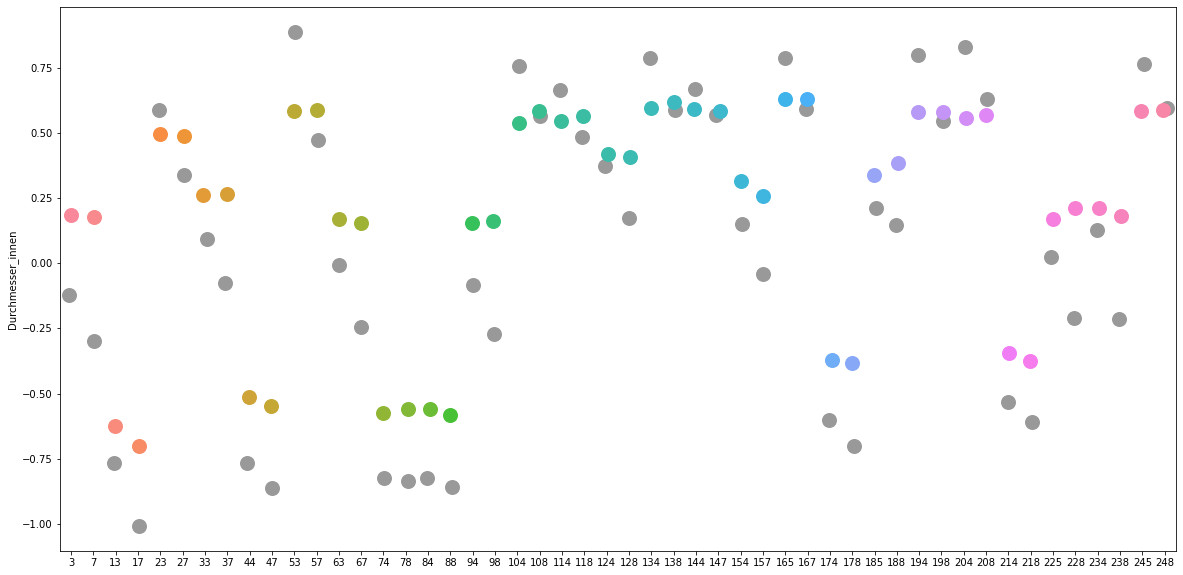

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=idx_plot,y=data_val.loc[idx_plot,'Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=idx_plot,y=prediction_q.loc[idx_plot,'Durchmesser_innen'],size=15,ax=ax)